In [ ]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Introducing Situated Projective Simulation 3.0

Bayesian state estimation provides a normative approach to updating ones beliefs about the state of the world. This approach, however, requires an accurate model of the transition probabilities between states and an accurate model of emission probabilities in each state (i.e. what the observer sees, or is likely to see). The real world is a massive, chaotic, open system; it is impossible that embodied agents navigating in that world come pre-equipped with such a model. How can such agents learn a model of the world that provides close-enough bayesian estimates of thier state, such that they can anticipate future scenarios? Episodic memory - the mental retrieval and replay of past events - appears to play an important role in how humans learn about the world and anticipate the future. Many animal also appear to rely on event-specific information retrieval to make adaptive decisions. While there is thus empirical evidence that episodic memory plays a role in mental model formation, it remains unclear how this process works. Situated Projective Simulatiom is a computational approach for understanding how episodic memory can be used to create and/or refine a mental model of the world through experience, such that the agent becomes able to make increasingly accurate predications about the future using Bayesian state estimation. SiPS also integrates insights from Active Inference, such that the agent not only learns to make better predictions, but to take actions that lead to a more predictable future.

In this document, I will introduce the various mechanisms of SiPS one-by-one. 

I begin with what I call the Bayesian Memory Network, which encodes memories in a graph struture with neural-network-like properties This structure enables approximate bayesian state estimation even in the absence of a true world model by sampling from memories as a function of their excitation from the agent's current sensory state and an expectation that is passed forward through time by recurrent connections. This process is akin to Bayesian Filtering. We show how the computed surprise of the graph can be used as a reward signal for a system of conditioned reflexes, enabling learning in Markov Decision Processes.

I then introduce the so-called Active Inference Memory Network, which expands on the Bayesian Memory Network by allowing the network to "prime" the agent's actions directly. This priming works in much the same way that the network sets expectations on sensory states, but in the case of actions these "priming" expectations are modulated by enocodings of how surprised the agent was in the sampled memory during which it previously took the action.

Finally, I discuss how the application of Projective Simulation - a deliberative model of decision making - to the Active Inference Memory Network may enable the agent to learn about conditional depencies between sensory states, to learn what components of its sensory signals are relevant and which are effectively noise, and to guide its actions by pro-actively imagining possible scenarios.

## The Bayesian Memory Network

Bayes' Theorem describes the probability of an event based on prior knowledge of conditions that might be related to the event. It is mathematically expressed as:

$$
P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}
$$

Where:

- $ P(A \mid B) $ is the **posterior probability**: the probability of event $ A $ given that $ B $ has occurred.
- $ P(B \mid A) $ is the **likelihood**: the probability of event $ B $ given that $ A $ is true.
- $ P(A) $ is the **prior probability**: the initial probability of event $ A $.
- $ P(B) $ is the **marginal probability**: the total probability of event $ B $.

### State Estimation using a Fixed State Bayesian Network with Uncorrelated, Bit-wise Sensory Elements

To build an intuition for how we can implement Bayes' Theorem on a neural-network-like graph, let's consider a simple example. We are given two coins, a nickel and quarter (so we can tell them apart), but we are told there is a 50% chance these coins are biased. If they are biased, there is an 80% chance the quarter comes up heads and only a 30% chance the nickel does. Given that we flip each coin once and observe the result, Figure 1 illustrates how we can implement Bayes Theorem on a graph to determine the probability that the coins were biased - using the case where the quarter came up heads and the nickel came up tails. The nodes on the left can be thought of as our sensory representations of a head's up quarter and nickel, respectively. The excitation state of the first of these bitwise sensory elements, $\dot{s}_1$, is equal to 1 if we see a heads up quarter and 0 otherwise. Likewise for the nickel and the excitation state $\dot{s}_2$ of the second bitwise sensory element. For now, we can think of the nodes on the right as states in our mental model of the scenario. The wieghts of edges connecting sensory elements to states in the mental model give the probability of exciting the conneted sensory element when the true world state is represented by the connected state in the mental model. We can think of the excitation of sensory elements being passed along the edges to the mental model nodes, such that the excitation state of mental model nodes is the product of all of its inputs. Thus, the excitation state of mental model node $j$ gives the joint likelihood of all excited (and unexcited) sensory elements, given the true world state $j$:

\begin{equation}
\dot{m}_\mathrm{j} = \prod_{\mathrm{i} = 1}^{\lvert\boldsymbol{S}\rvert} w_\mathrm{ij}^{\dot{s}_\mathrm{i}}(1-w_\mathrm{ij})^{1-\dot{s}_\mathrm{i}} = P(B \mid A = j),
\end{equation}

Where $\lvert S \rvert$ denotes the number of sensory elements and $B$, the event that has already occured, is given by $(\dot{s}_1, . . ., \dot{s}_{\lvert S \rvert})$.

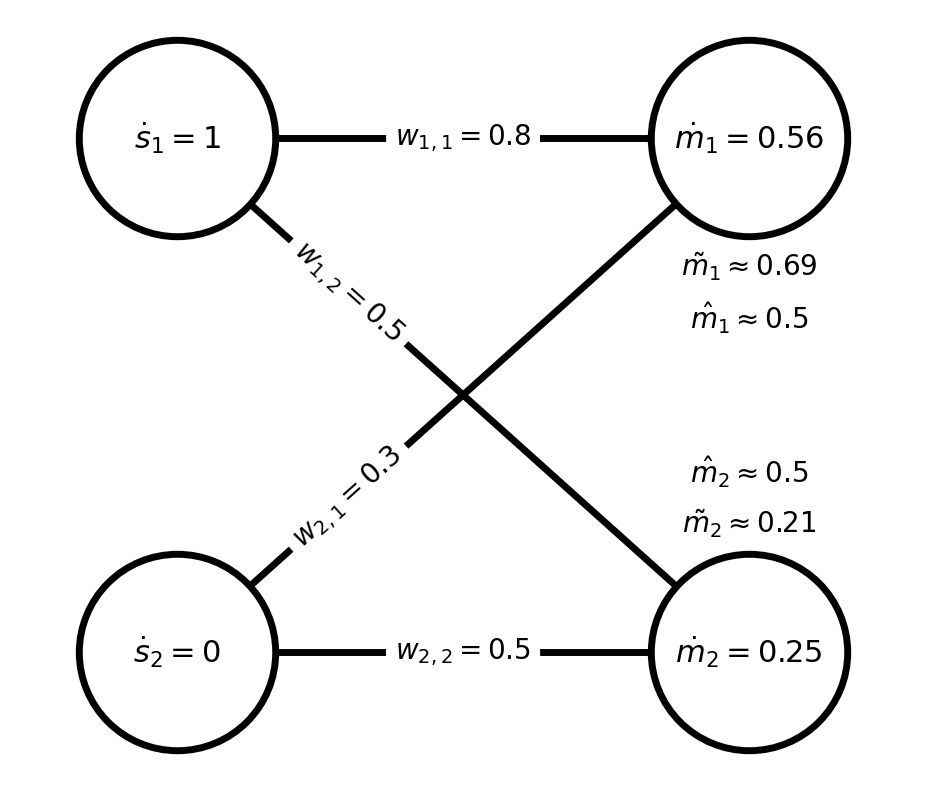

In [ ]:
# Create the bipartite graph
B_updated = nx.Graph()

# Define node labels
node_labels = {
    r"$\dot{s}_1=1$": r"$\dot{s}_1=1$",
    r"$\dot{s}_2=0$": r"$\dot{s}_2=0$",
    r"$\dot{m}_1=0.56$": r"$\dot{m}_1=0.56$",
    r"$\dot{m}_2=0.25$": r"$\dot{m}_2=0.25$",
}

# Add nodes to the graph
B_updated.add_nodes_from(node_labels.keys())

# Define edges with labels
edge_labels_corrected = {
    (r"$\dot{s}_1=1$", r"$\dot{m}_1=0.56$"): r"$w_{1,1} = 0.8$",
    (r"$\dot{s}_1=1$", r"$\dot{m}_2=0.25$"): r"$w_{1,2} = 0.5$",
    (r"$\dot{s}_2=0$", r"$\dot{m}_1=0.56$"): r"$w_{2,1} = 0.3$",
    (r"$\dot{s}_2=0$", r"$\dot{m}_2=0.25$"): r"$w_{2,2} = 0.5$",
}

# Add edges to graph
for u, v in edge_labels_corrected.keys():
    B_updated.add_edge(u, v)

# Define positions for nodes
adjusted_pos = {
    r"$\dot{s}_1=1$": (-1.2, 1),
    r"$\dot{s}_2=0$": (-1.2, -1),
    r"$\dot{m}_1=0.56$": (1.2, 1),
    r"$\dot{m}_2=0.25$": (1.2, -1),
}

# Plot the updated graph with adjusted arrow positions
plt.figure(figsize=(12, 10))

# Adjust plot limits for full visibility
plt.xlim(-1.9, 2)
plt.ylim(-1.5, 1.5)

# Reduce text sizes for better fit
node_font_size = 22
edge_label_font_size = 20

# Draw nodes and edges
nx.draw(
    B_updated, adjusted_pos, labels=node_labels, node_color="white", edge_color="black",
    node_size=20000, font_size=node_font_size, linewidths=5, edgecolors="black", width=5
)

# Draw edge labels
for (u, v), label in edge_labels_corrected.items():
    label_pos = 0.7  # Default label position
    if (u, v) == (r"$\dot{s}_1=1$", r"$\dot{m}_1=0.56$") or (u, v) == (r"$\dot{s}_2=0$", r"$\dot{m}_2=0.25$"):
        label_pos = 0.5  # Keep these at 0.5
    nx.draw_networkx_edge_labels(B_updated, adjusted_pos, edge_labels={(u, v): label}, font_size=edge_label_font_size, label_pos=label_pos)

# Update label values
plt.text(1.2, 0.5, r"$\tilde{m}_1 \approx 0.69$", fontsize=edge_label_font_size, ha="center", va="center")
plt.text(1.2, -0.5, r"$\tilde{m}_2 \approx 0.21$", fontsize=edge_label_font_size, ha="center", va="center")

# Add expectation labels
plt.text(1.2, 0.3, r"$\hat{m}_1 \approx 0.5$", fontsize=edge_label_font_size, ha="center", va="center")
plt.text(1.2, -0.3, r"$\hat{m}_2 \approx 0.5$", fontsize=edge_label_font_size, ha="center", va="center")

plt.show()

The prior probability of the two states in our mental model, $P(A)$, was given in the problem statement: 50% for each. We will notate the prior probability of the state represented in our mental model by a node $j$ as $\hat{m}_j$. To get the probability of our sensory state, $P(B)$, we simply need the sum of $P(B \mid A=j)P(A=j)$ for all nodes $j$ in our mental model. Thus

\begin{equation}
\tilde{m}_j = P(A=j \mid B) = \frac{P(B \mid A=j)P(A)}{P(B)} = \frac{\dot{m}_j\hat{m}_j}{\sum_{j'=1}^{\lvert M \rvert}\dot{m}_{j'}\hat{m}_{j'}},
\end{equation}

where $\tilde{m}_j$ is the activation of the node representing state $j$ in our mental model and $\lvert M \rvert$ is the number of states in our mental model. Note that that this operation is the same as normalizing the excitation-expectation-product across all mental model nodes.

Thus, we can describe the excitation of mental model nodes as a feed-forward operation on the Bayesian Network, parameterized by the prior probailities (i.e. expectation states) of the mental model nodes. This excitation gives the likelihood of the sensory state, given that the mental model node represents the true world state. We can then descrive the activation state of a mental model node as the normalization of all mental model node excitations. Given that the Bayesian Graph is an accurate representation of the true world states, the activation state of a mental model node gives the probability that the node represents the true world state.


### Filtering using a Bayesian Network for State Estimation Given First Order Correlations In World State Sequences 

If the probabilities of transitioning from a given world state any other world state are known, the posterior probabilites of all states in the mental model can be used to determine prior probalities for those states in the future. For example, consider a simple case where it is known that coin flips alternate between the biased and unbiased states - as depicted in Figure 2. We can represent these transitions in a mental model by estblishing directed "clip edges" between mental model nodes (we will arrive at the reason for naming them 'clip edges later); if the weights of all clip edges that lead from one state in the mental model are normalized, they give the probability of transition from that state to the state to which the edge leads. Thus: given a set of posterior probabilities and a transtion model, the prior probability of the next state can be computed as

\begin{equation}
\hat{m}^{(t+1)}_{j'} = \sum_{j=1}^{\lvert M \rvert}\tilde{m}_j^{(t)} c_{jj'},
\end{equation}

where $c_{jj'}$ is the normalized clip edge weight from node j in the mental model to node j' in the mental model. The forward propogation of variables in the resulting graph enables the Bayesian Network to integrate sensory evidence over time and reduce uncertainty regarding the true state. This process is known as Bayesian Filtering.

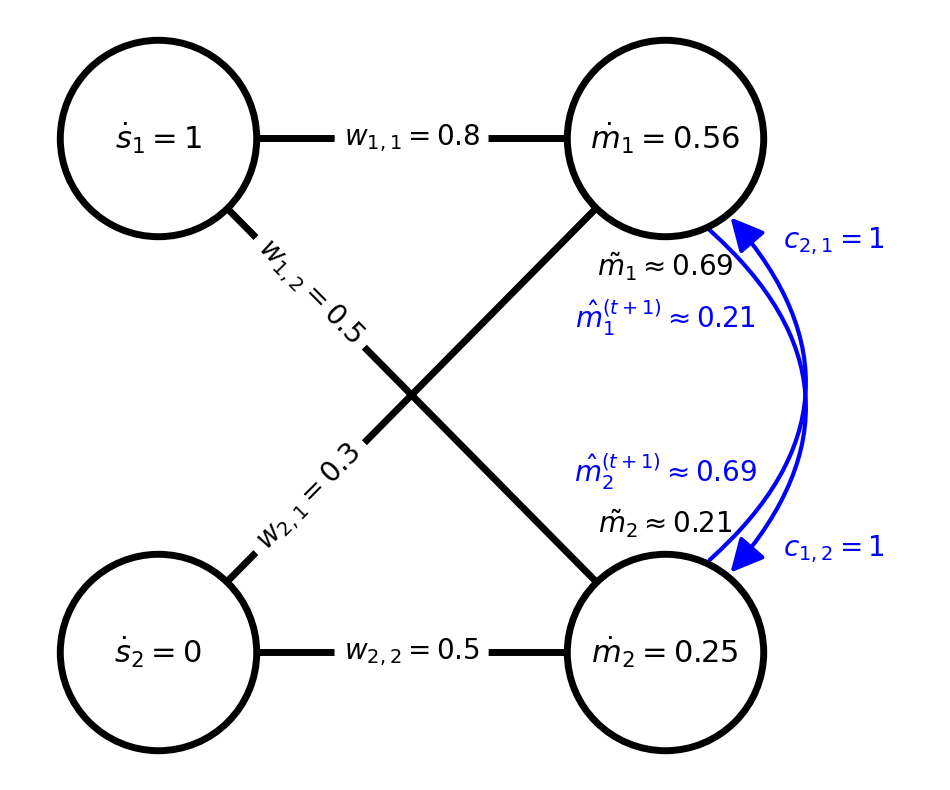

In [ ]:
# Create the bipartite graph
B_updated = nx.Graph()

# Define node labels
node_labels = {
    r"$\dot{s}_1=1$": r"$\dot{s}_1=1$",
    r"$\dot{s}_2=0$": r"$\dot{s}_2=0$",
    r"$\dot{m}_1=0.56$": r"$\dot{m}_1=0.56$",
    r"$\dot{m}_2=0.25$": r"$\dot{m}_2=0.25$",
}

# Add nodes to the graph
B_updated.add_nodes_from(node_labels.keys())

# Define edges with labels
edge_labels_corrected = {
    (r"$\dot{s}_1=1$", r"$\dot{m}_1=0.56$"): r"$w_{1,1} = 0.8$",
    (r"$\dot{s}_1=1$", r"$\dot{m}_2=0.25$"): r"$w_{1,2} = 0.5$",
    (r"$\dot{s}_2=0$", r"$\dot{m}_1=0.56$"): r"$w_{2,1} = 0.3$",
    (r"$\dot{s}_2=0$", r"$\dot{m}_2=0.25$"): r"$w_{2,2} = 0.5$",
}

# Add edges to graph
for u, v in edge_labels_corrected.keys():
    B_updated.add_edge(u, v)

# Define positions for nodes
adjusted_pos = {
    r"$\dot{s}_1=1$": (-1.2, 1),
    r"$\dot{s}_2=0$": (-1.2, -1),
    r"$\dot{m}_1=0.56$": (1.2, 1),
    r"$\dot{m}_2=0.25$": (1.2, -1),
}

# Plot the updated graph with adjusted arrow positions
plt.figure(figsize=(12, 10))

# Adjust plot limits for full visibility
plt.xlim(-1.9, 2.5)
plt.ylim(-1.5, 1.5)

# Reduce text sizes for better fit
node_font_size = 22
edge_label_font_size = 20

# Draw nodes and edges
nx.draw(
    B_updated, adjusted_pos, labels=node_labels, node_color="white", edge_color="black",
    node_size=20000, font_size=node_font_size, linewidths=5, edgecolors="black", width=5
)

# Draw edge labels
for (u, v), label in edge_labels_corrected.items():
    label_pos = 0.7  # Default label position
    if (u, v) == (r"$\dot{s}_1=1$", r"$\dot{m}_1=0.56$") or (u, v) == (r"$\dot{s}_2=0$", r"$\dot{m}_2=0.25$"):
        label_pos = 0.5  # Keep these at 0.5
    nx.draw_networkx_edge_labels(B_updated, adjusted_pos, edge_labels={(u, v): label}, font_size=edge_label_font_size, label_pos=label_pos)

# Update label values
plt.text(1.2, 0.5, r"$\tilde{m}_1 \approx 0.69$", fontsize=edge_label_font_size, ha="center", va="center")
plt.text(1.2, -0.5, r"$\tilde{m}_2 \approx 0.21$", fontsize=edge_label_font_size, ha="center", va="center")

# Manually add a curved directed edge with an explicit arrowhead at node borders
ax = plt.gca()

# First directed edge (m1 to m2)
arrow1 = FancyArrowPatch(
    (1.4, 0.65), (1.5, -0.7),
    connectionstyle="arc3,rad=-0.5",  # Strong leftward curve
    arrowstyle="-|>",  # Explicit arrowhead
    mutation_scale=50,  # Arrowhead size
    color="blue",
    linewidth=3
)

# Second directed edge (m2 to m1)
arrow2 = FancyArrowPatch(
    (1.4, -0.65), (1.5, 0.7), 
    connectionstyle="arc3,rad=0.5",  # Strong rightward curve
    arrowstyle="-|>",  # Explicit arrowhead
    mutation_scale=50,  # Arrowhead size
    color="blue",
    linewidth=3
)

ax.add_patch(arrow1)
ax.add_patch(arrow2)

# Position the directed edge labels
plt.text(2.0, -0.6, r"$c_{1,2} = 1$", fontsize=edge_label_font_size, ha="center", va="center", color="blue")
plt.text(2.0, 0.6, r"$c_{2,1} = 1$", fontsize=edge_label_font_size, ha="center", va="center", color="blue")

# Add expectation labels
plt.text(1.2, 0.3, r"$\hat{m}_1^{(t+1)} \approx 0.21$", fontsize=edge_label_font_size, ha="center", va="center", color = "blue")
plt.text(1.2, -0.3, r"$\hat{m}_2^{(t+1)} \approx 0.69$", fontsize=edge_label_font_size, ha="center", va="center", color = "blue")


# Show the final refined graph with correctly positioned arrows
plt.show()


Thus far, we have introduced a new notation for describing a neural-network-like implementation for Bayesian Filtering. Why? Embodied agents may face situations in which they do not already posses a mental model of the possible states, the probabilities of sensations in those states, and the transition probailities bewteen states. Memory of previous sequences of sensations may serve as template models for the future state estimation, but an embodied agent must be capable of encoding those memories in a way that enables both Bayesian state estimation and the ability to learn which memories - and which aspects of those memories - are useful as models for future state estimation. We will now use the framework and notation established to show how a system of episodic memory encoding that follows the same principles as a Bayesian Network can usefully approximate a Fixed State Bayesian Network that accurately models the true world states, while creating a foundation upon which other learning processes can guide the mental model to accurately reflect complex systems in the world that the agent cannot directly observe.

### Replacing Fixed States with Episodic Memory Traces in a Bayesian Network

Let us now think of $m$ nodes in the mental model not as representing world states but as reprenting *episodic memories*; we will call them **memory traces**. We will assume for now that the agent has some number, $\lvert M \rvert$, memory traces available to it, and that prior to observing any sensory states the weights in $\boldsymbol{W}$ and $\boldsymbol{C}$ are all $0$. Now let us say that whenever the agent observes a new sensory state, it encodes that observation into its episodic memory by selecting a memory trace adding weight to relevent edges connected to that trace. If we want the memory trace to represent exactly the state of the world when it was encoded, we could set the weight of edges connected to excited sensory elements to 1, and also set the weight of the clip edge that points from the last encoded trace to the being-encoded trace to 1. If we do this, however, the trace will only ever be activated if the agent has just observed the *exact* sequence of sensory states that preceded the being-encoded memory trace. What we want instead is for the memory trace to represent (or come to represent) the properties of the world state at the time the trace was encoded that are relevent to the agent's ability to predict it's future sensory states. There must therefore be some possibility that in the future the trace becomes activated even when the agent's curent history of sensory states does not match its history of sensory states at the time the trace was encoding. We can allow this by setting the previously noted edges to some weight slightly below 1, and all other edges leading to the being-encoded trace to weights slightly above 0. Figure 3 shows the edge weights of such a Bayesian Memory Network after two observations - first a heads-up quarter and tails-up nickel, then both coins heads up.

By itself, this approach is not going to do a good job of approximating the true system; the traces are not connected to sensory elements with weights that resemble the true observation probabilites of the system and we have not devised a way to fix this. Before we consider approaches to address this issue, let us consider a different example for which the established system *per se* can usefully approximate a fixed-state model of the true system. Now let's say we have a system where in one state the quarter, and only the quarter, always comes up heads.

In [ ]:
from projective_simulation.agents import Situated_Agent
from projective_simulation.environments import Timed_Response, Delayed_Response
from projective_simulation.ECMs import Active_Inference_Memory_Network
from projective_simulation.methods.preprocessors import action_factorizor
import nbdev
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ECM = Active_Inference_Memory_Network(num_actions = 3, N_traces = 200, intrinsic_sensory_expectations = np.array([2]), gnosticism = 2) #we give the agent a single intrisic expectation. An agent preprocessor must be set up to appropriately connect this expectation to the correct sensory state
test_SiPS = Situated_Agent(num_actions = 3, reflex_softmax = 2, ECM = ECM, percept_processor = action_factorizor(percept_dict = {"1": {"1": 3}}, num_actions = 3))
test_env = Delayed_Response(W = 1, N = 2, max_trial_length=2)

trial_num = 0
reward_attained = False
total_trials = 100
action = None
trial_data = np.empty(shape = (total_trials,4)) #each trial, will collect the presented stimulus, the selected action, the trial length, and wether the reward was attained

In [ ]:
if test_env.state["trial_time"] == 0: #check if new trial
    trial_data[trial_num,0] = test_env.state["current_stimulus"] #record which stimulus the agent was presented with

print(test_env.state)
print("beliefs")
print(test_SiPS.ECM.trace_expectations[0:20])
print("expectations")
print(test_SiPS.ECM.percept_expectations)

observation = test_env.get_observation()
action = test_SiPS.get_action(observation)
print("Action: " + str(action))
#check if agent acted after wait period to collect data
if test_env.state["trial_time"] >= test_env.W and not action == 0: 
    trial_data[trial_num,1] = action
    trial_data[trial_num,2] = test_env.state["trial_time"]
    trial_data[trial_num,3] = test_env.state["rewarded_action"] == action

test_env.transition(action)
#if transition starts new trial, increase counter (ends experiment if final trial)
if test_env.state["trial_time"] == 0: #check if new trial
    trial_num += 1

print("excitations")
print(test_SiPS.ECM.trace_excitations[0:20])
print("activations")
print(test_SiPS.ECM.trace_activations[0:20])

{'current_stimulus': 1, 'rewarded_action': 1, 'reward_available': False, 'trial_time': 0}
beliefs
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005]
expectations
[0.00990099 0.00990099 0.00990099 0.53548166]
Action: 1
excitations
[0.00000000e+00 1.50054239e-08 1.50054239e-08 1.50054239e-08
 1.50054239e-08 1.50054239e-08 1.50054239e-08 1.50054239e-08
 1.50054239e-08 1.50054239e-08 1.50054239e-08 1.50054239e-08
 1.50054239e-08 1.50054239e-08 1.50054239e-08 1.50054239e-08
 1.50054239e-08 1.50054239e-08 1.50054239e-08 1.50054239e-08]
activations
[0.         0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513]


In [ ]:
test_SiPS.ECM.W

array([[-1, -2, -2, ..., -2, -2, -2],
       [ 1, -2, -2, ..., -2, -2, -2],
       [-1, -2, -2, ..., -2, -2, -2],
       [-1, -2, -2, ..., -2, -2, -2],
       [ 1, -2, -2, ..., -2, -2, -2],
       [ 1, -2, -2, ..., -2, -2, -2]])

In [ ]:
test_SiPS.ECM.memory_valences

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [ ]:
while trial_num < total_trials:
    
    if test_env.state["trial_time"] == 0: #check if new trial
        trial_data[trial_num,0] = test_env.state["current_stimulus"] #record which stimulus the agent was presented with
        
    observation = test_env.get_observation()
    action = test_SiPS.get_action(observation)
    #check if agent acted after wait period to collect data
    if test_env.state["trial_time"] >= test_env.W and not action == 0: 
        trial_data[trial_num,1] = action
        trial_data[trial_num,2] = test_env.state["trial_time"]
        trial_data[trial_num,3] = test_env.state["rewarded_action"] == action

    test_env.transition(action)
    #if transition starts new trial, increase counter (ends experiment if final trial)
    if test_env.state["trial_time"] == 0: #check if new trial
        print("trial " + str(trial_num) + " results: " + str(trial_data[trial_num,0:]))
        trial_num += 1

trial 0 results: [1. 1. 1. 1.]
trial 1 results: [1. 2. 1. 0.]
trial 2 results: [1. 2. 2. 0.]
trial 3 results: [2. 1. 2. 0.]
trial 4 results: [1. 1. 1. 1.]
trial 5 results: [2. 2. 2. 1.]
trial 6 results: [2. 1. 1. 0.]
trial 7 results: [2. 1. 2. 0.]
trial 8 results: [1. 2. 2. 0.]
trial 9 results: [1. 1. 1. 1.]
trial 10 results: [2. 1. 1. 0.]
trial 11 results: [2. 2. 2. 1.]
trial 12 results: [2. 2. 2. 1.]
trial 13 results: [2. 1. 2. 0.]
trial 14 results: [2. 1. 2. 0.]
trial 15 results: [1. 2. 1. 0.]
trial 16 results: [1. 2. 1. 0.]
trial 17 results: [2. 1. 2. 0.]
trial 18 results: [2. 1. 2. 0.]
trial 19 results: [1. 2. 2. 0.]
trial 20 results: [2.00000000e+000 6.95199766e-310 6.95199766e-310 6.95199766e-310]
trial 21 results: [1.00000000e+000 6.95199766e-310 6.95199766e-310 6.95199766e-310]
trial 22 results: [1. 1. 2. 1.]
trial 23 results: [1. 1. 2. 1.]
trial 24 results: [1. 2. 2. 0.]
trial 25 results: [2. 2. 2. 1.]
trial 26 results: [2. 2. 2. 1.]
trial 27 results: [1. 2. 1. 0.]
trial 28 r

In [ ]:
ECM = Active_Inference_Memory_Network(num_actions = 2, simulation_determinism = 5, kappa = 4, N_traces = 40, intrinsic_sensory_expectations = np.array([3]), gnosticism = 1) #we give the agent a single intrisic expectation. An agent preprocessor must be set up to appropriately connect this expectation to the correct sensory state
test_SiPS = Situated_Agent(num_actions = 2, reflex_softmax = 5, ECM = ECM, percept_processor = action_factorizor(percept_dict = {"1": {"1": 2}}, num_actions = 2))
test_env = Timed_Response(delay = 1)

T = 400
t = 0
data = np.full(shape = (T,2), fill_value = None)


In [ ]:
print(np.round(test_SiPS.ECM.trace_expectations, decimals = 3))

data[t,0] = test_env.state
observation = test_env.get_observation()
action = test_SiPS.get_action(observation)
data[t,1] = action
test_env.transition(action)
t += 1

print(data[0:t,].transpose())
print(np.round(test_SiPS.ECM.trace_activations, decimals = 3))

[0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025]
[[0]
 [1]]
[0.    0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026
 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026
 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026
 0.026 0.026 0.026 0.026]


[<matplotlib.lines.Line2D>]

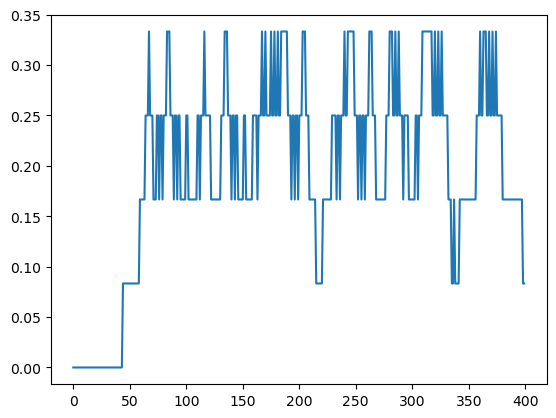

In [ ]:
while t < T:
    data[t,0] = test_env.state
    observation = test_env.get_observation()
    action = test_SiPS.get_action(observation)
    data[t,1] = action
    test_env.transition(action)
    t += 1

success = [data[i,0] == 3 for i in range(T)]
plt.plot(range(T), [np.sum(success[max(0,i-11):i+1])/len(success[max(0,i-11):i+1]) for i in range(T)])